# ConvLSTM for forecasting

- without uncertainty

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import os, sys
import pandas as pd

- import **deephydro module** with networks, losses and metrics

In [2]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

# Data import

- paths

In [3]:
#os.chdir("/Users/schmidle/Documents/GIT-Projects/DeepHydro")
data_folder = '/data/debacwa/DeepHydro'
data_prec = '01_prec.nc'
data_temp = '01_temp.nc'
data_disc = '01_discharge.csv'

- read output data

In [101]:
def read_output_data(data_folder:str, data_disc:str):
    # read csv file
    df = pd.read_csv(os.path.join(data_folder, data_disc))
    # calculate fractional day of year
    df['DOY'] = pd.DatetimeIndex(df['Time']).dayofyear / 365
    return df

In [102]:
df = read_output_data(data_folder, data_disc)
df.head()

Unnamed: 0        Time      Q       DOY
0       27455  1950-01-01  558.0  0.002740
1       27456  1950-01-02  547.0  0.005479
2       27457  1950-01-03  541.0  0.008219
3       27458  1950-01-04  541.0  0.010959
4       27459  1950-01-05  564.0  0.013699

In [6]:
def plot_streamflow(df, n_labels=10):
    fig, ax = plt.subplots()
    ax.plot(df['Time'], df['Q'])
    ax.xaxis.set_major_locator(plt.MaxNLocator(n_labels)) # limit number of dates on x axis
    fig.autofmt_xdate() # rotate data labels
    plt.show()

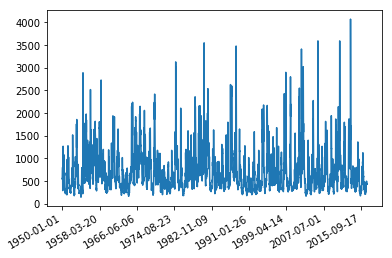

In [7]:
plot_streamflow(df)

- read input data (NetCDF4)

In [8]:
def read_data(filename, folder, varname):
    import netCDF4
    dat = netCDF4.Dataset(os.path.join(folder, filename))
    print(filename)
    arr = np.array(dat.variables[varname])
    mask = arr < 0
    arr[ mask ] = 0.0
    return arr, mask

def plot_frame(temp:np.array, prec:np.array, mask:np.array, df:pd.DataFrame, frame:int, limits:tuple=None):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    im_t = np.ma.masked_array(temp[frame], mask=mask[frame])
    im_p = np.ma.masked_array(prec[frame], mask=mask[frame])
    
    ax[0].set_title('Temperature')
    if limits is None:
        cb1 = ax[0].imshow(im_t)
    else:
        cb1 = ax[0].imshow(im_t, vmin=limits[0], vmax=limits[1])
    fig.colorbar(cb1, ax=ax[0], orientation='horizontal')

    ax[1].set_title('Precipitation')
    if limits is None:
        cb2 = ax[1].imshow(im_p)
    else:
        cb2 = ax[1].imshow(im_p, vmin=limits[2], vmax=limits[3])
    fig.colorbar(cb2, ax=ax[1], orientation='horizontal')
    
    for a in ax: a.axis('off')
        
    plt.show()


In [9]:
temp, mask = read_data(data_temp, data_folder, varname='z (unknown)')
prec, mask = read_data(data_prec, data_folder, varname='z (unknown)')

01_temp.nc
01_prec.nc


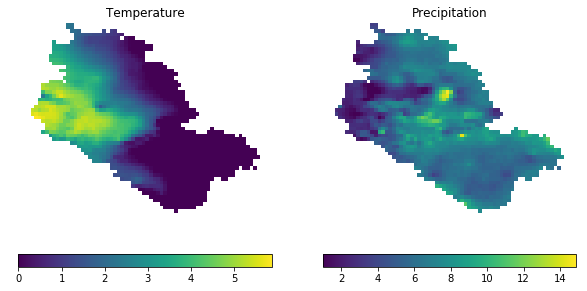

In [10]:
plot_frame(temp, prec, mask, df, frame=11)

# Data preparation

- standardize output data (`y`)

In [11]:
def standardize(data:np.array, return_moments=False):
    mean = np.mean(data)
    std = np.std(data)
    if return_moments:
        return (data-mean)/std, mean, std
    else:
        return (data-mean)/std

Shape of y =  (24472,)


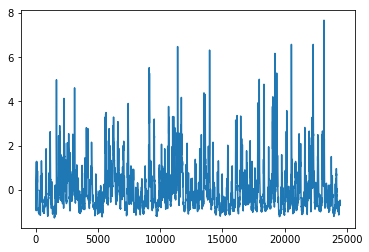

In [12]:
y, Y_MEAN, Y_STD = standardize(df['Q'].values, return_moments=True)
print('Shape of y = ', y.shape)

# plot data
plt.plot(y)

- standardize and combine input image (`x`)

Shape of x =  (24472, 53, 66, 2)


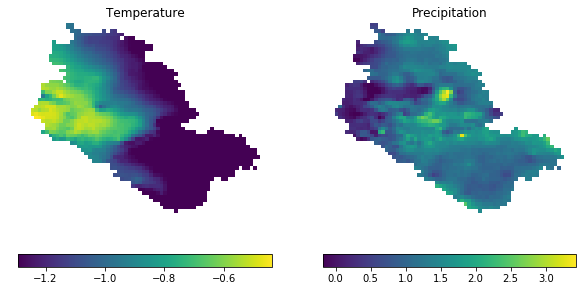

In [13]:
x_t = standardize(np.ma.masked_array(temp, mask=mask))
x_p = standardize(np.ma.masked_array(prec, mask=mask))
x = np.stack([x_t, x_p], axis=-1)
print('Shape of x = ', x.shape)

# plot sample frame
plot_frame(x_t, x_p, mask, df, frame=11)

In [103]:
x_doy = df['DOY'].values
print(x_doy)


[0.00273973 0.00547945 0.00821918 ... 0.99726027 1.         1.00273973]


- split train and test set
   - here: we don't use `train_test_split` anymore because we are dealing with sequences.
   - we simply take the first part as training data, and the last part as test data

In [14]:
# only use first 10% of data
#x = x[:len(x)//10]
#y = y[:len(y)//10]


In [110]:
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)

train_size = int(0.75 * len(x))
x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]
x_train_doy, x_test_doy = x_doy[:train_size], x_doy[train_size:]

In [111]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_test  = ', x_test.shape)
print('Shape of y_test  = ', y_test.shape)


Shape of x_train =  (18354, 53, 66, 2)
Shape of y_train =  (18354,)
Shape of x_test  =  (6118, 53, 66, 2)
Shape of y_test  =  (6118,)


## Data generator

To sample image sequences, we do not store of all possible image sequences to memory. This would imply storing a lot of overlapping (=redundant) data.

Instead, we use a generator to generate a batch of random sequences. We could build a simple generator function using the `yield` statement, but to exploit parallel processing during batch generation, we will extend the `keras.utils.Sequence` class. 

In [148]:
# length of image sequence
n_frames = 30
# adjust this to available GPU memory (VRAM)
batch_size = 128

# use day of year ?
day_of_year = True
# forecasting ?
forecasting = False
# uncertainty estimation ?
uncertainty = False


In [149]:
from deephydro.generator import ImageSequenceGenerator
generator_train = ImageSequenceGenerator(data=x_train, labels=y_train, doy=x_train_doy,
                                         batch_size=batch_size, n_frames=n_frames, 
                                         day_of_year=day_of_year, forecasting=forecasting, uncertainty=uncertainty)
generator_test  = ImageSequenceGenerator(data=x_test,  labels=y_test,  doy=x_test_doy,
                                         batch_size=batch_size, n_frames=n_frames, 
                                         day_of_year=day_of_year, forecasting=forecasting, uncertainty=uncertainty)

In [150]:
batch = generator_train.__getitem__(0)
print(f'Shape of batch_x = {batch[0].shape}')
print(f'Shape of batch_y = {batch[1].shape}')


AttributeError: 'list' object has no attribute 'shape'

In [151]:
#batch[0][0][1]

# Model

- load model
- predicts the streamflow from a short sequence of temperature and precipitation...

In [158]:
input_shape = (n_frames, *x_train.shape[1:])
from deephydro import networks
model = networks.nowcasting_model(input_shape, dayofyear=day_of_year)
model.summary()

256
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 30, 53, 66, 2 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_89 (ConvLSTM2D)    (None, 30, 26, 32, 1 10432       images[0][0]                     
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 30, 26, 32, 1 64          conv_lst_m2d_89[0][0]            
__________________________________________________________________________________________________
conv_lst_m2d_90 (ConvLSTM2D)    (None, 30, 12, 15, 3 55424       batch_normalization_67[0][0]     
__________________________________________________________________________________________________
batch_

- compile model: loss, optimizer and metrics

In [159]:
from keras import optimizers
from deephydro.losses import mse, logcosh, gauss
from deephydro.metrics import ccc_keras

if uncertainty:
    loss=gauss
else:
    loss=logcosh
    
model.compile(optimizer=optimizers.Adam(lr=1e-3),
         loss=loss,
         metrics=[ccc_keras])
             

- check output shapes et al

In [22]:
#output = model.evaluate_generator( generator=generator_test,steps=1)
#for name, value in zip(model.metrics_names, output):
#    print(f'{name} = {value:.3f}')

In [23]:
batch = generator_test.__getitem__(0)
y_true = batch[1]
print('--- y_true ---')
print(len(y_true))
for p in y_true:
    print(p.shape)
    print(p)

    
print()
print('--- y_pred ---')
y_pred = model.predict(batch[0], batch_size=1)

print(len(y_pred))
for p in y_pred:
    print(p.shape)
    print(p)
    #print(f'mean   = {p[..., 0]}')
    #print(f'logvar = {p[..., 1]}')
    
    
print()
print('--- loss ---')
from deephydro import losses
from keras import backend as K 
loss = K.eval(losses.gauss(K.variable(y_true), K.variable(y_pred)))
print('loss shape = ', loss.shape)
print(loss)

print()
print('--- ccc ---')
from deephydro import metrics
ccc = K.eval(metrics.ccc_keras(K.variable(y_true), K.variable(y_pred)))
print('ccc = ', ccc.shape)
print(ccc)


--- y_true ---
128
(1,)
[-0.74665857]
(1,)
[-0.70632182]
(1,)
[0.0394478]
(1,)
[-0.22385947]
(1,)
[-0.09252588]
(1,)
[-1.09311083]
(1,)
[2.32358083]
(1,)
[0.6012078]
(1,)
[-0.76139419]
(1,)
[-0.21788003]
(1,)
[-0.75382479]
(1,)
[-1.04233227]
(1,)
[0.05458661]
(1,)
[-1.10729976]
(1,)
[-0.82614756]
(1,)
[0.51756395]
(1,)
[-0.5993274]
(1,)
[0.39718925]
(1,)
[0.0329695]
(1,)
[-0.26972692]
(1,)
[-0.30332568]
(1,)
[0.53056838]
(1,)
[-0.13110865]
(1,)
[0.01175786]
(1,)
[-0.54940761]
(1,)
[-0.74535334]
(1,)
[1.28468417]
(1,)
[-0.86406519]
(1,)
[0.39517788]
(1,)
[-0.10654852]
(1,)
[-0.70252915]
(1,)
[0.17889749]
(1,)
[-0.40927]
(1,)
[0.70225239]
(1,)
[1.70811975]
(1,)
[1.84816397]
(1,)
[-0.41921296]
(1,)
[0.77760474]
(1,)
[1.3476904]
(1,)
[2.49114186]
(1,)
[-0.96345604]
(1,)
[-0.66304206]
(1,)
[-0.97190698]
(1,)
[1.86807266]
(1,)
[-0.65097839]
(1,)
[0.53680978]
(1,)
[-1.14429029]
(1,)
[-0.94552227]
(1,)
[-0.41641116]
(1,)
[-0.21510557]
(1,)
[-0.17688042]
(1,)
[-0.87554799]
(1,)
[0.06173005]
(1,

KeyboardInterrupt: 

In [ ]:
batch = generator_train.__getitem__(0)
y_true = batch[1]
y_pred = model.predict(batch[0], batch_size=1)

In [ ]:
y_pred.shape

In [566]:
from deephydro.metrics import ccc_numpy
metrics.ccc_numpy(y_true, y_pred)


y_pred.shape = (64, 30, 2)
y_true.shape = (64, 30, 1)
y_pred.ndim = 3
y_true.ndim = 3
...
y_pred.shape = (64, 30)
y_true.shape = (64, 30)
y_pred.ndim = 2
y_true.ndim = 2


array([3.74295192e-06, 2.50297846e-05, 8.05285251e-05, 2.31586813e-04,
       3.50781002e-04, 6.70906282e-04, 9.27649702e-04, 1.47022797e-03,
       1.52108452e-03, 2.88413743e-03, 3.53630047e-03, 3.99110173e-03,
       4.27218916e-03, 4.71424258e-03, 5.64107144e-03, 5.36937721e-03,
       4.77387540e-03, 5.70252641e-03, 4.03568710e-03, 4.47587504e-03,
       4.07619059e-03, 5.91309632e-03, 4.82070446e-03, 3.70261657e-03,
       3.99894435e-03, 5.23821079e-03, 5.97242957e-03, 7.48448314e-03,
       6.21770670e-03, 7.59040547e-03])

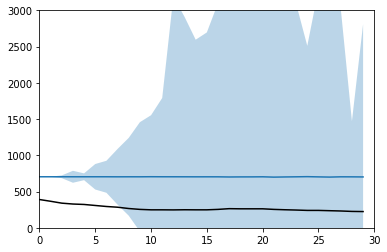

In [574]:
def plot_forecast(y_true_sample, y_pred_sample):
    
    x = range(len(y_true_sample))
    y = y_pred_sample[:,0]*Y_STD+Y_MEAN
    err = y_pred_sample[:,1]*Y_STD * 500.0
    gt = y_true_sample[:,0]*Y_STD+Y_MEAN
    plt.plot(x, y)
    plt.fill_between(x,y-err, y+err,alpha=0.3)
    plt.plot(x, gt, color='black')
    plt.xlim((0,len(y_true_sample)))
    plt.ylim((0,3000))


random_ind = np.random.randint(0, len(y_true))
plot_forecast(y_true[random_ind], y_pred[random_ind])
    

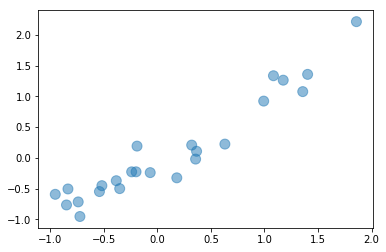

In [393]:
var = np.exp(y_pred[...,1])
plt.scatter(y_true, y_pred[...,0], s=var*100, alpha=0.5)

# Training

In [118]:
n_epochs = 20

In [ ]:
history = model.fit_generator(generator=generator_train,
                              steps_per_epoch=len(x_train)//batch_size,
                              epochs=n_epochs,
                              validation_data=generator_test,
                              validation_steps=len(x_test)//batch_size,
                              use_multiprocessing=True,
                              workers=7,
                              max_queue_size=128)
                             

Epoch 1/20
143/143 [==============================] - 127s 885ms/step - loss: 0.1104 - ccc_keras: 0.8102 - val_loss: 0.2205 - val_ccc_keras: 0.5243
Epoch 2/20
143/143 [==============================] - 117s 818ms/step - loss: 0.0765 - ccc_keras: 0.8822 - val_loss: 0.2338 - val_ccc_keras: 0.5362
Epoch 3/20
143/143 [==============================] - 112s 787ms/step - loss: 0.0533 - ccc_keras: 0.9224 - val_loss: 0.2143 - val_ccc_keras: 0.5678
Epoch 4/20
101/143 [====================>.........] - ETA: 28s - loss: 0.0516 - ccc_keras: 0.9280

In [61]:
model.save('./model_nowcasting.h5')

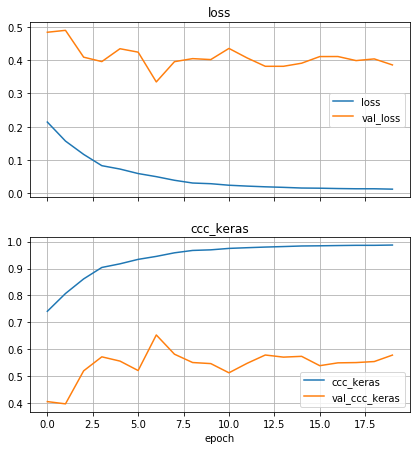

In [78]:
from deephydro.utils import plot_history
plot_history(history=history)

# Predict

In [420]:
def predict(model, image, gt=None, plot=False):
    
    im = image[np.newaxis, ...] # add batch dimension

    t = im[..., 0] # get temperature
    p = im[..., 1] # get precipitation

    y_pred = model.predict(im)[0,0] # get first element

    # calculate back to original units
    y_pred = Y_MEAN + y_pred * Y_STD

    if plot:
        limits = (t.min(), t.max(), p.min(), p.max())
        for frame in range(len(t[0])):
            print(f'Day {frame+1}')
            plot_frame(t[:,frame], p[:,frame], mask, df, 0, limits=limits)

    if gt is not None:
        y_true = Y_MEAN + gt * Y_STD
        if plot:
            print(f'Predicted streamflow = {y_pred:.1f}, ground truth = {y_true:.1f}')
        return y_pred, y_true
    else:
        print(f'Predicted streamflow = {y_pred:.1f}')
        return y_pred

Day 1


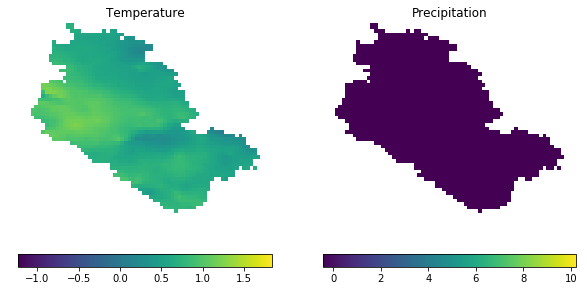

Day 2


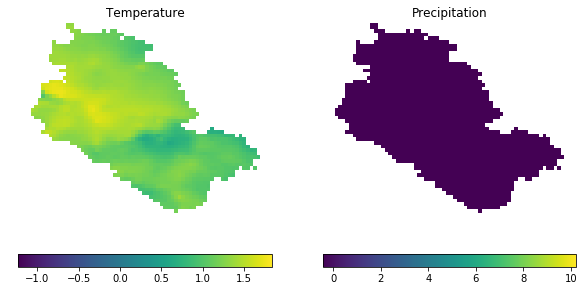

Day 3


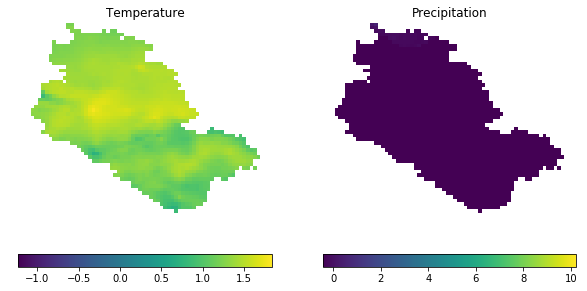

Day 4


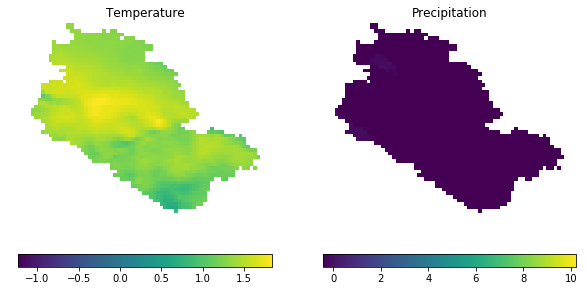

Day 5


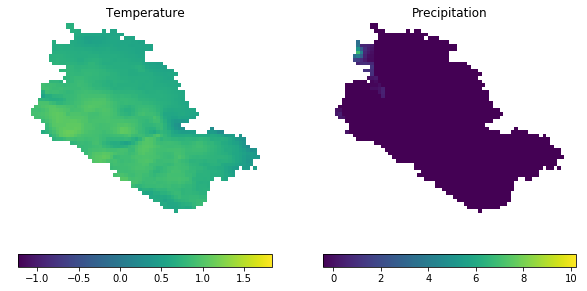

Day 6


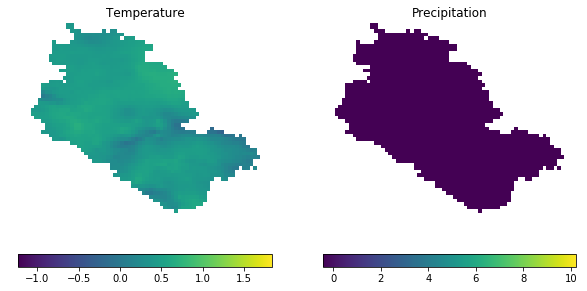

Day 7


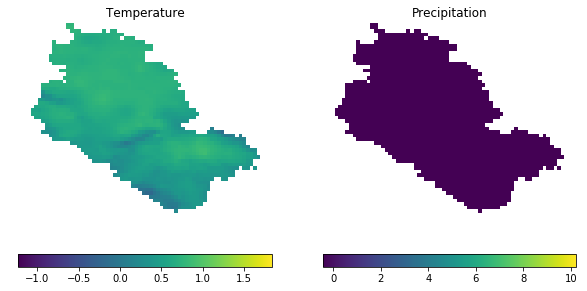

Day 8


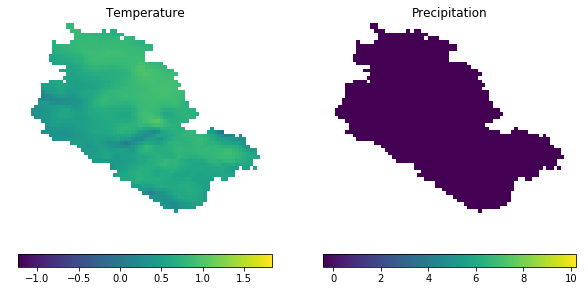

Day 9


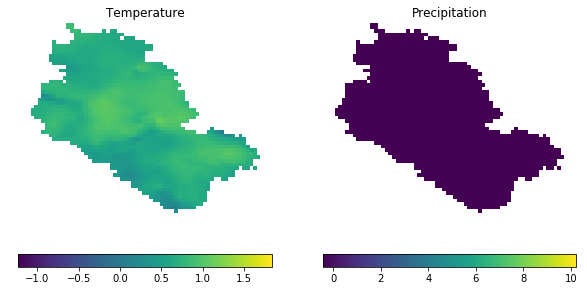

Day 10


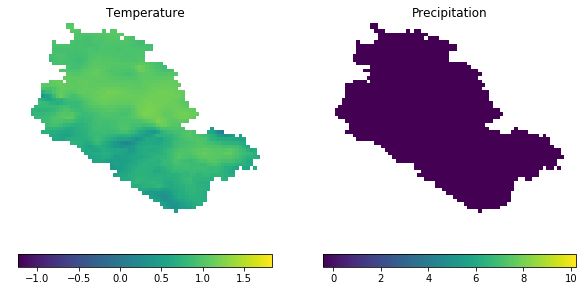

Day 11


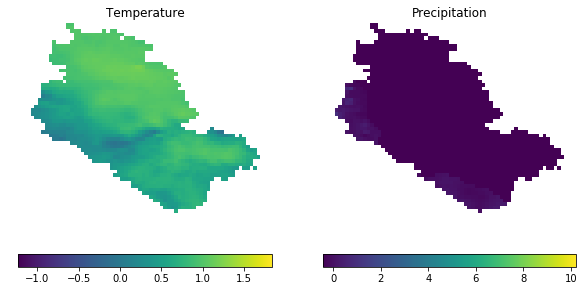

Day 12


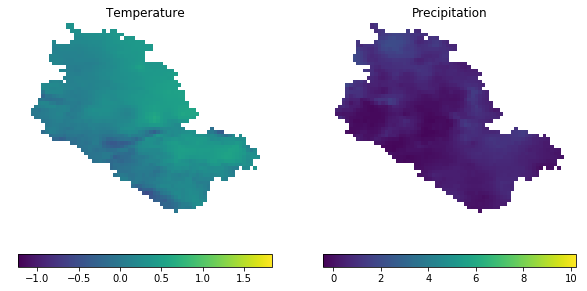

Day 13


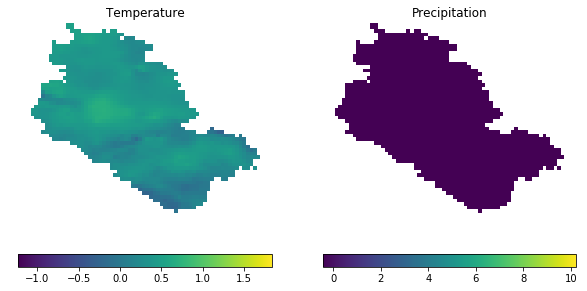

Day 14


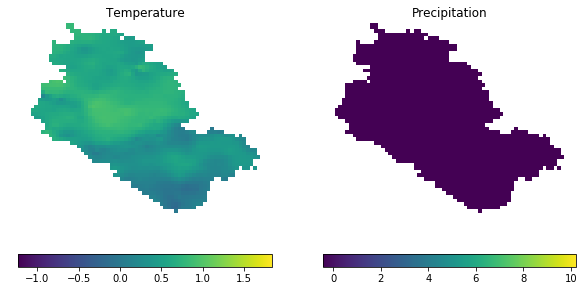

Day 15


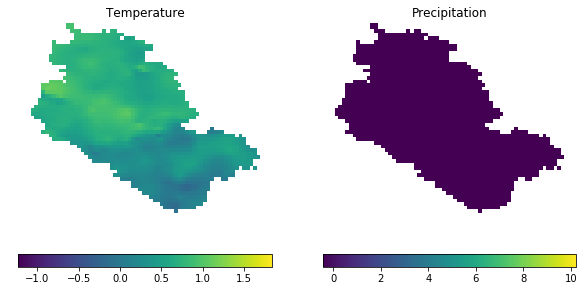

Day 16


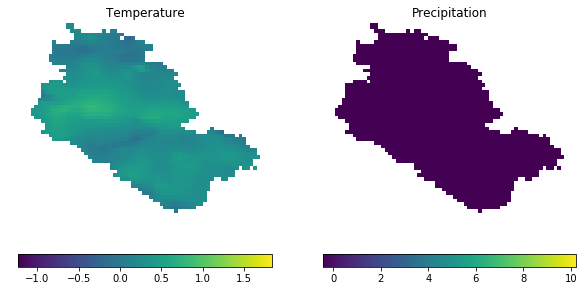

Day 17


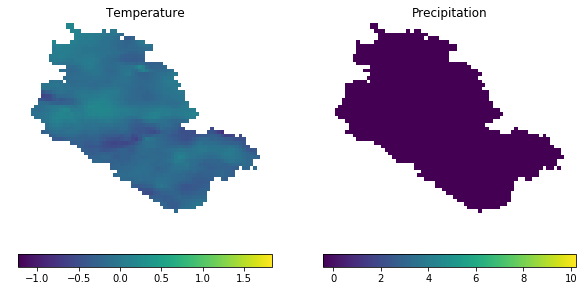

Day 18


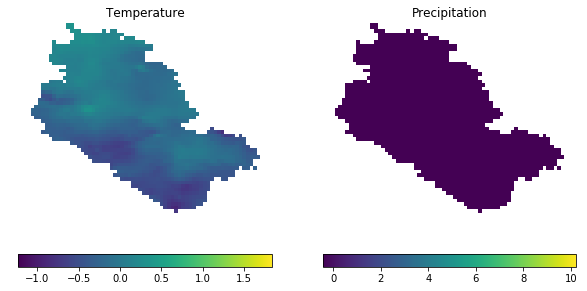

Day 19


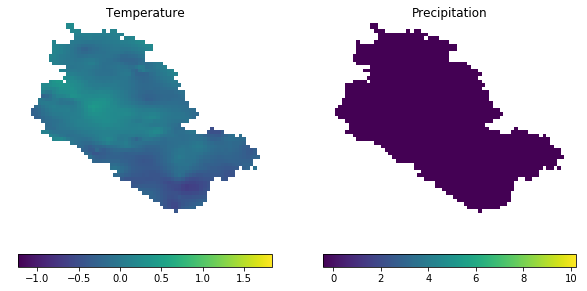

Day 20


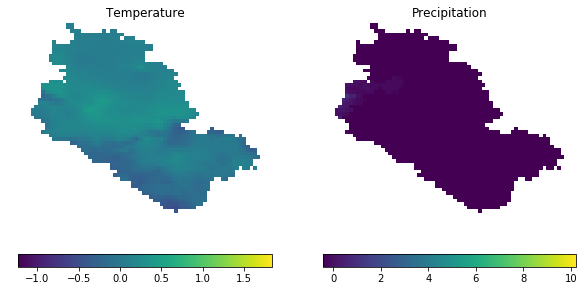

Day 21


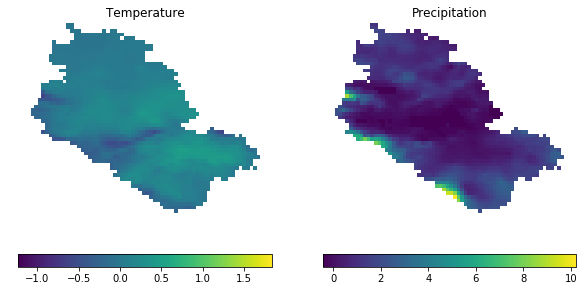

Day 22


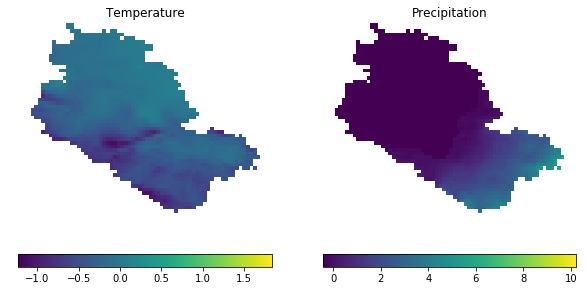

Day 23


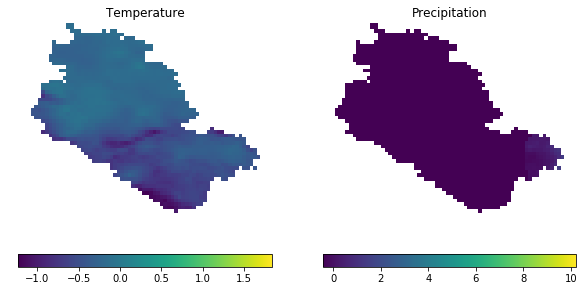

Day 24


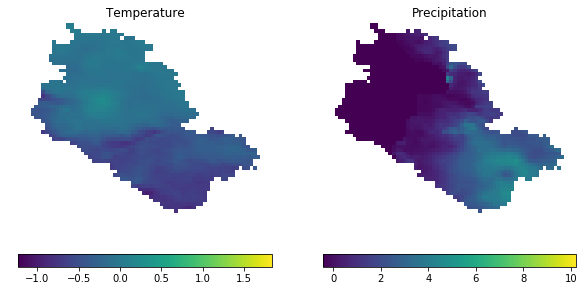

Day 25


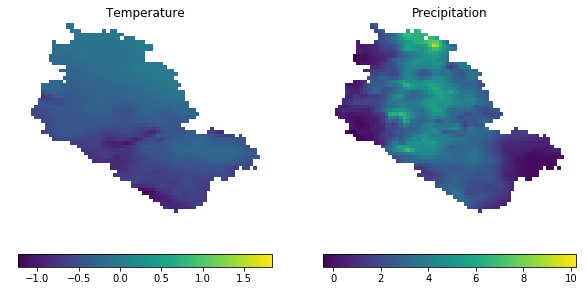

Day 26


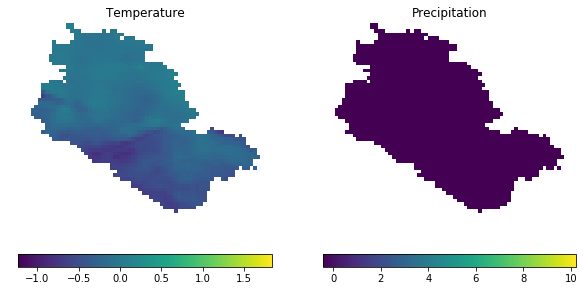

Day 27


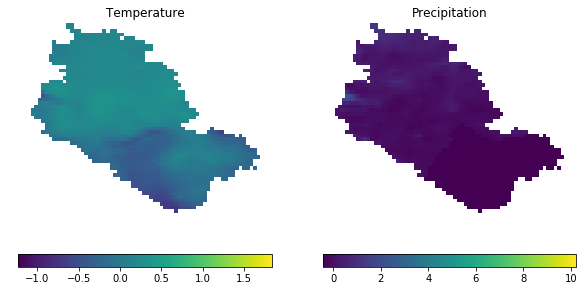

Day 28


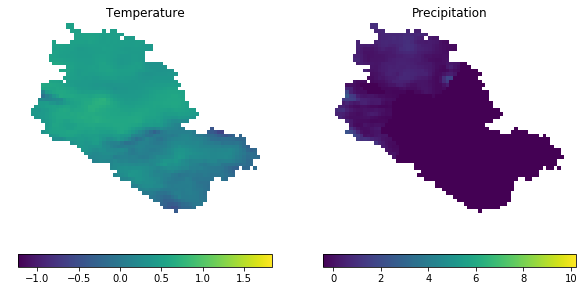

Day 29


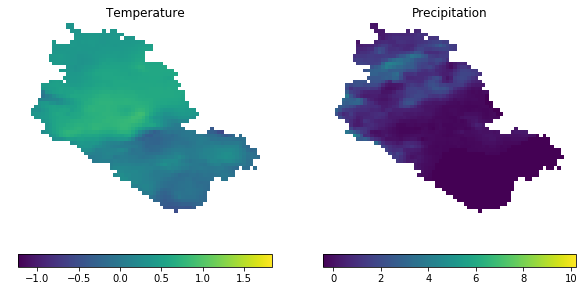

Day 30


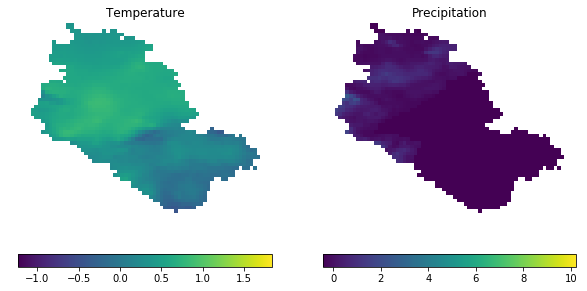

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [421]:
random_test_sample = generator_test.__getitem__(0) # get single sample from batch
_ = predict(model, random_test_sample[0][0], gt=random_test_sample[1][0], plot=True)

## Evaluate prediction accuracy

- predict streamflow in multiple image sequences
- compare with ground truth streamflow
- using Lin's concordance correlation coefficient - basically Pearson correlation, corrected for bias


(153.75792011680664,
 1856.8643224902823,
 100.63482339955857,
 2132.3651766004414)

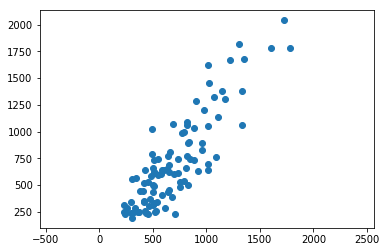

In [395]:
y_preds, y_trues = [], []
from tqdm import tqdm_notebook as tqdm
for _  in tqdm(range(100)):
    random_test_sample = generator_test.__getitem__(0) # get single sample from batch
    y_pred, y_true = predict(model, random_test_sample[0][0], gt=random_test_sample[1][0], plot=False)
    y_preds.append(y_pred)
    y_trues.append(y_true)

plt.scatter(y_preds, y_trues)
plt.axis('equal')


In [398]:
def ccc_numpy(y_true, y_pred):
    import numpy as np
    '''Lin's Concordance correlation coefficient: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient'''
    
    # covariance between y_true and y_pred
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    s_xy = np.cov([y_true, y_pred], bias=True)[0,1] #[1,0] is the identical covariance between y_pred and y_true 
    # means
    x_m = np.mean(y_true)
    y_m = np.mean(y_pred)
    # variances
    s_x_sq = np.var(y_true)
    s_y_sq = np.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2)
    
    return ccc

In [399]:
print(f'Concordance correlation coefficient  = {ccc_numpy(y_trues, y_preds):.3f}')

Concordance correlation coefficient  = 0.838


# Saliency map

- using a variant of `DeepLIFT` called `DeepShap` based on Shapley values and implemented in the package [`shap`](https://github.com/slundberg/shap)


```
conda install -c conda-forge shap
pip install tqdm --upgrade # I needed to upgrade tqdm (progress bar)
```

In [63]:
#from keras.models import load_model
#model = load_model('./model.h5')

In [64]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
# return a list of tuples
background = np.mean(np.array([np.mean(generator_train.__getitem__(0)[0], axis=0) for _ in range(20)]), axis=0)
print(background.shape)
print(background[np.newaxis, ...].shape)

# explain predictions
e = shap.DeepExplainer(model, background[np.newaxis, ...])

test_sample = random_test_sample[0][0]
shap_values = e.shap_values(test_sample[np.newaxis, ...])

# plot the feature attributions
#shap.image_plot(shap_values, -test_sample[np.newaxis, 0, ..., 0])

/Users/wdeback/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(7, 53, 66, 2)
(1, 7, 53, 66, 2)


In [65]:
print(len(shap_values))
print(shap_values[0].shape)
print(shap_values[0][0].shape)

1
(1, 7, 53, 66, 2)
(7, 53, 66, 2)


- plot saliency map

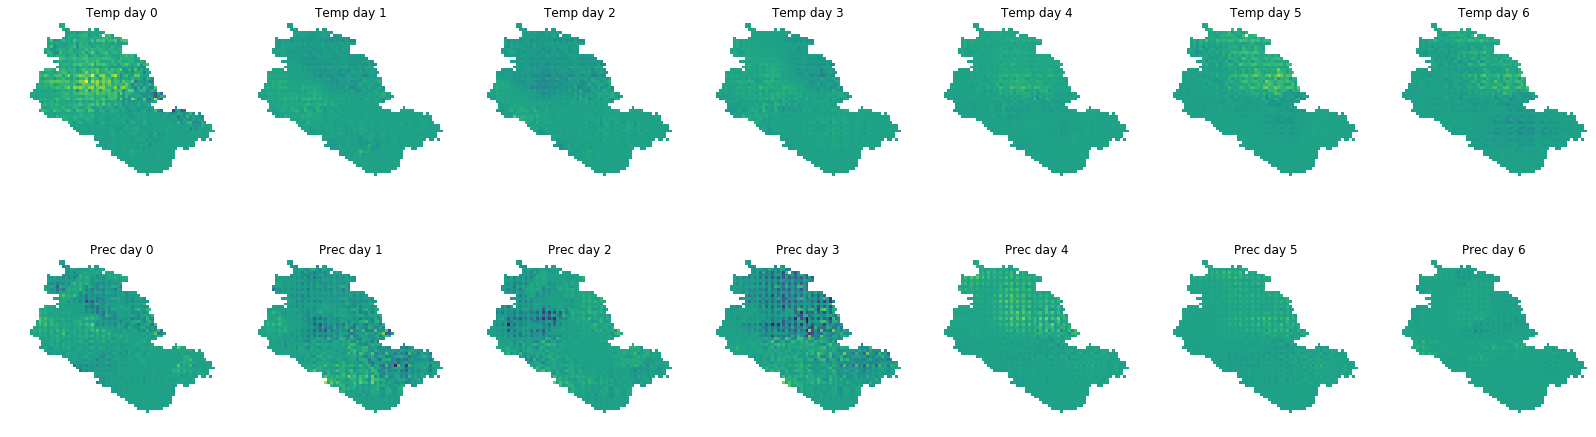

In [66]:
fig, ax = plt.subplots(2, n_frames, figsize=(n_frames*4, 2*4)) 

for frame in range(len(shap_values[0][0])):
    
    ax[0,frame].set_title(f'Temp day {frame}')#'{-n_frames+frame+1}')
    vmin = np.min( shap_values[0][0])
    vmax = np.max( shap_values[0][0])

    vmin_t = np.min( shap_values[0][0, ..., 0])
    vmax_t = np.max( shap_values[0][0, ..., 0])
    im_t = np.ma.masked_array(shap_values[0][0, frame, ..., 0], mask=mask[frame])
    ax[0, frame].imshow(im_t, vmin=vmin, vmax=vmax)
    ax[0, frame].axis('off')
    
    ax[1, frame].set_title(f'Prec day {frame}')#'{-n_frames+frame+1}')
    vmin_p = np.min( shap_values[0][0, ..., 1])
    vmax_p = np.max( shap_values[0][0, ..., 1])
    im_p = np.ma.masked_array(shap_values[0][0, frame, ..., 1], mask=mask[frame])
    ax[1, frame].imshow(im_p, vmin=vmin, vmax=vmax)
    ax[1, frame].axis('off')
    
    
plt.show()